# Modelo de predicción de morosos de préstamos

## Introducción (5 mts)

Se explorarán 3 modelos de aprendizaje de máquina supervisado: Regresión logística, Clasificador Bayesiano Ingenuo y Bosque Aleatorio sobre el problema de aprobación de préstamos

## Evaluar el modelo logístico (20 mts)

In [2]:
import pandas as pd
import numpy  as np
from scipy.stats import chi2_contingency, norm
import statsmodels.api as sm
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.externals.six import StringIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy import interp
from statsmodels.formula.api import ols
import seaborn as sns

import pydotplus
from IPython.display import SVG
from graphviz import Source
from IPython.display import Image
from sympy import var, plot_implicit, Eq

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');

C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
df = pd.read_csv("Lending_club_cleaned_2.csv", \
                 dtype = {"loan_status":"category", "annual_inc":"float", \
                          "verification_status":"category", "emp_length":"category", \
                          "home_ownership":"category", "int_rate":"object",\
                          "loan_amnt":"float", "purpose":"category",\
                          "term":"category", "grade":"category"})
df.int_rate = df.int_rate.str.rstrip("%").astype("float")

In [4]:
df.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000.0,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500.0,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400.0,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000.0,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000.0,other,60 months,B


Modelo logístico

Optimization terminated successfully.
         Current function value: 0.378195
         Iterations 7


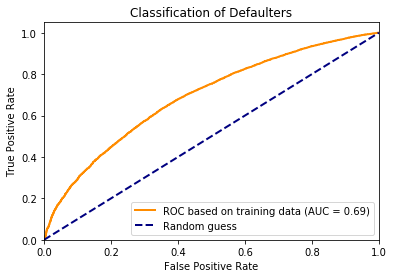

In [5]:
# Ajustar columnas para el modelo
df_log2 = pd.concat([(df.loan_amnt - df.loan_amnt.mean())/df.loan_amnt.std(),\
                     (df.int_rate - df.int_rate.mean())/df.int_rate.std(),\
                     (df.annual_inc - df.annual_inc.mean())/df.annual_inc.std(),\
                     pd.get_dummies(df.home_ownership, prefix="home", drop_first=True), \
                     pd.get_dummies(df.purpose, prefix="purpose", drop_first=True), \
                     pd.get_dummies(df.grade, prefix="grade",drop_first=True)], axis=1)
df_log2["verification_status"] = df.verification_status.cat.codes
df_log2["emp_length"] = df.emp_length.cat.codes
df_log2["term"] = df.term.cat.codes
df_log2["Intercept"] = 1

# Ajuste
logit_full1 = sm.Logit(df.loan_status.cat.codes, df_log2)
logit_full1_res = logit_full1.fit()

# Graficar curva ROC
predict_withvs = logit_full1_res.predict(df_log2)

roc_vs = roc_curve(df.loan_status.cat.codes, predict_withvs)
auc_vs = auc( roc_vs[0], roc_vs[1] )

plt.figure()
lw = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange',
         lw=lw, label='ROC based on training data (AUC = %0.2f)' % auc_vs)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc="lower right")
plt.show()

### Ejercicio 1: (15 mts)
Validación cruzada con 10 pliegues, con el AUC promedio

**Respuesta.**

In [6]:
# Validación cruzada

def cv_roc(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        logit = sm.Logit(y.iloc[train], X.iloc[train])
        logit_res = logit.fit(disp=0)
        probas_ = logit_res.predict(X.iloc[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


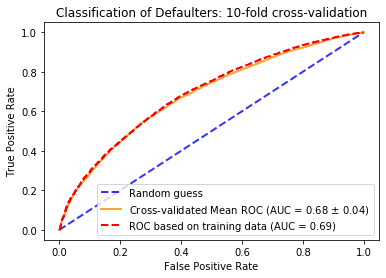

In [7]:
# Graficar
tprs_vs, aucs_vs, mean_fpr_vs = cv_roc(df_log2, df.loan_status.cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
         label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange',
         label=r'Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_vs, std_auc_vs),
         lw=2, alpha=.8)

plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--',
         lw=lw, label='ROC based on training data (AUC = %0.2f)' % auc_vs)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Classification of Defaulters: 10-fold cross-validation')
plt.show()

El AUC es un poco más pequeño que el calculado con los datos de entrenamiento. La diferencia es pequeña, indicando que no hay problema de sobreajuste, lo cual también se evidencia en la cercanía de las curvas de entrenamiento y d validación cruzada

En ocasiones es mejor utilizar algoritmos que no se recuestan en supuestos sobre las variables explicativas y la probabilidad del resultado.

## Clasificador Bayesiano Ingenuo (65 mts)

### Probabilidad condicional y teorema de Bayes (5 mts)

**Probabilidad condicional: conditional probability (CP)**. La probabilidad condicional de un evento $A$ dado el evento $B$ se define como la probabilidad de observar el evento $A$ dado que $B$ ya haya sucedido. Numericamente:

$$
\text{CP($A$ given $B$)} = \frac{\text{P($A$ and $B$)}}{\text{P($B$)}}.
$$

Se pueden invertir los eventos:

$$
\text{CP($B$ given $A$)} = \frac{\text{P($B$ and $A$)}}{\text{P($A$)}}.
$$

Como los numeradores de ambas ecuaciones son iguales podemos igualarlos y despejar:

$$
\text{CP($A$ given $B$)}\text{P($B$)} = \text{CP($B$ given $A$)}\text{P($A$)} \\
\rightarrow\text{CP($A$ given $B$)} = \frac{\text{CP($B$ given $A$)}\text{P($A$)}} {\text{P($B$)}} \\
$$

Este es el famoso **Teorema de Bayes**.

### Introduciendo el algoritmo (10 mts)


La probabilidad condicional se puede expresar de la siguiente manera:
$$
\text{CP(defaulter given covariates=values)} = \frac{\text{CP(covariates=values given defaulter)P(defaulter)}}{\text{P(covariates=values)}}.
$$

1. $\text{P(defaulter)}$. Probabilidad de que haya un moroso, se puede estimar como la proporción de estos en el conjunto de datos.
2. $\text{P(covariates=values)}$. Probabilidad de que un cliente cuyas variables sean iguales a los valores. Esta cantidad no tiene que ser estimada.
3. $\text{CP(covariates=values given defaulter)}$. Proporción de morosos cuyas variables sean igual a $\text{values}$. Si hay muchas variables, el número de morosos podría ser pequeño, el desafío consiste en construir un clasificador que estime esta probabilidad en particular.

Primero entendamos por qué cuando el número de variables es difícil de estimar $\text{CP(covariates=values given defaulter)}$ en proporciones directamente.

### Ejercicio 3 (5 mts)

Asuma que tenemos 10 covariables y que todas son binarias. ¿Cuál es el número mínimo de muestras para que sea posible tener al menos una muestra por cada combinación de valores de estas covariables?

**Respuesta.**
2 a la 10 = 1024

### ¿Por qué el clasificador es ingenuo? (5 mts)

El clasificador realiza el supuesto de que *todas las covariables son independientes cuando están condicionadas por los resultados*. Puede que esto nunca sea cierto, pero aún así, los resultados pueden ser muy poderosos la mayoría del tiempo.

En este caso, el supuesto implica que entre cumplidos y morosos, todas las covariables se encuentran independientemente distribuidas:

$$
\text{CP(covariates=values given defaulter)} = \text{CP(covariate}_1\text{=value}_1\text{ given defaulter)}\times\cdots\times\text{CP(covariate}_p\text{=value}_p\text{ given defaulter)}
$$

Aquí asumimos que hay $p$ covariables en total. Veamos por qué reduce el número de muestras requeridas para estimar las proporciones.


### Ejercicio 4: (5 mts)

Bajo los supuestos del ejercicio 3, más la de independencia, ¿cuántas muestras se necesitan para estimar la probabilidad condicional $\text{CP(covariates=values given defaulter)}$?

**Respuesta.**
Necesitamos estimar $p$ probabilidades condicionales donde cada una contiene una variable binaria, con 2 posibles resultados. Solo se necesitan $2\times 10=20$ muestras ahora. Lo cual es mucho menos que $1024$.

### Ejercicio 5: (5 mts)

Usando los datos disponibles, estime $\text{CP(term given defaulter)}$ y $\text{CP(verfication_status given defaulter)}$ para todos los diferentes valores de `term` y de `verification_status`.

**Respuesta.**

In [8]:
# Probabilidades condicionales
df_default = df[df.loan_status=="Charged Off"]
# term (plazo)
print("Conditional probability of term given defaulter:")
print((df_default.term.value_counts()/df_default.shape[0]));
print("")
# verification_status
print("Conditional probability of verification_status given defaulter:")
print(df_default.verification_status.value_counts()/df_default.shape[0]);

Conditional probability of term given defaulter:
 36 months    0.56489
 60 months    0.43511
Name: term, dtype: float64

Conditional probability of verification_status given defaulter:
Not Verified       0.376838
Verified           0.363419
Source Verified    0.259743
Name: verification_status, dtype: float64


Cuando la covariable es continua, la proporción dada por lo general cero. Para resolver esto utilizamos la densidad para representar la probabilidad condicional. La densidad depende de la distribución de los datos; en el clasificador bayesiano, se asume que los datos se distribuyen normal (la segunda razón por la cual es ingenuo).

Una distribución normal se caracteriza por su media y varianza, así que una distribución normal con media igual a la media de muestra y varianza igual a la varianza de muestra de la covariable es una buena estimación. Una vez obtenida esta distribución, la densidad se puede calcular directamente para cualquier valor de covariable.


Grafiquemos las distribuciones de las covariables del conjunto de datos, estratificadas por estado del préstamo.

### Ejercicio 8: (10 mts)

Use la función `violinplot()` del paquete `seaborn` de las variables continuas: `loan_amnt`, `annual_inc` y `int_rate` para cumplidos y morosos: es decir con la variable `loan_status` en el eje x. ¿Se evidencia alguna diferencia entre las distribuciones? Se satisface el supuesto del clasificador bayesiano?

**Respuesta.**

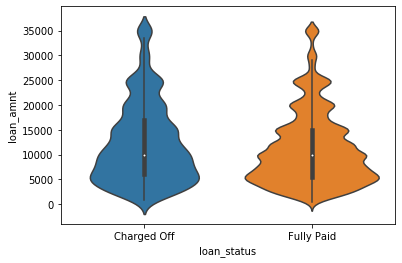

In [13]:
# Gráfico
sns.violinplot(x = df.loan_status, y = df.loan_amnt)

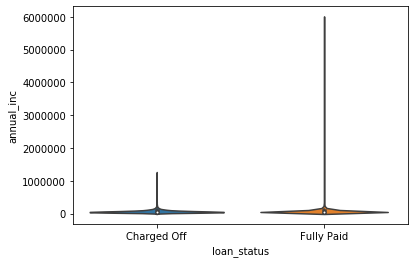

In [14]:
sns.violinplot(x = df.loan_status, y = df.annual_inc)

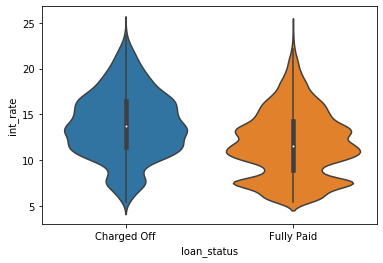

In [15]:
sns.violinplot(x = df.loan_status, y = df.int_rate)

Para las distribuciones del tipo de interés se ve la diferencia entre los dos tipos de usuarios. Para el monto del préstamo también es diferente, donde los cumplidos tienen más préstamos en pequeñas cantidades (alrededor de 5000).

Realicemos una transformación logarítmica para el ingreso anual puesto que se ve sesgada:

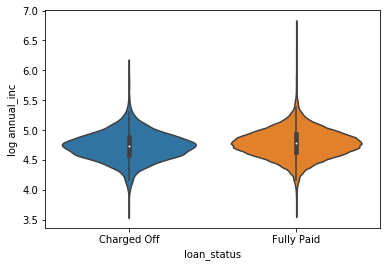

In [12]:
ax = sns.violinplot(x = df.loan_status, y = np.log10(df.annual_inc));
ax.set(ylabel='log annual_inc');

Se ve que la diferencia no es mucha.

La distribución de `int_rate` es lo suficientemente cercana a una normal, pero la de `loan_amnt` se ve sesgada: apliquemos una transformación cuadrática.

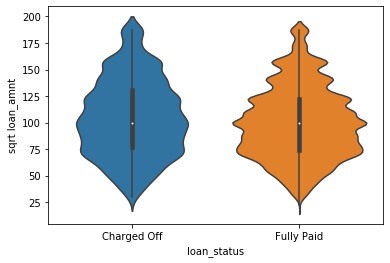

In [13]:
ax = sns.violinplot(x = df.loan_status, y = np.sqrt(df.loan_amnt));
ax.set(ylabel='sqrt loan_amnt');

Mejor.

Usaremos las variables con sus respectivas transformaciones para el clasificador:

In [16]:
df["annual_inc_log"] = np.log10(df.annual_inc)
df["loan_amnt_sqrt"] = np.sqrt(df.loan_amnt)

## Implementando el clasificador (30 mts)

Función

In [17]:
"""
Learn parameters for continuous covariate
y is a binary outcome
X is a pandas series of a continuous covariate
"""
def nb_fit_con(y, X):
    y_code = y.cat.codes
    X_0 = X[y_code==0]
    X_1 = X[y_code==1]
    return [[np.mean(X_0), np.std(X_0)], [np.mean(X_1), np.std(X_1)]]

### Ejercicio 9: (5 mts)

Escriba una función `nb_fit_dis` que estime las probabildiades de cada nivel de una covariable discreta para morosos y cumplidos. Esta función retorna una lista que contiene 2 listas. El primer elemento corresponde a las probabildiades de los morosos.

**Answer.** One possible solution is shown below:

In [18]:
"""
Learn parameters for discrete covariate
y is a binary outcome
X is a pandas series of a discrete covariate
"""
def nb_fit_dis(y, X):
    y_code = y.cat.codes
    X_code = X.cat.codes
    X_nlvl = len(X.cat.categories)
    
    X_0 = X_code[y_code==0]
    X_1 = X_code[y_code==1]
    
    X_0_freq = [np.sum(X_0==x)/len(X_0) for x in range(X_nlvl)]
    X_1_freq = [np.sum(X_1==x)/len(X_1) for x in range(X_nlvl)]
    return [X_0_freq, X_1_freq]

La siguiente función utiliza las funciones anteriores para entrenar el clasificador:

In [19]:
"""
y is a binary outcome
X is a pandas dataframe of covariates
"""
def train_nb_classifier( y, X ):
    trained_model = {}
    for ind_col in X.columns:
        # check data type
        if X[ind_col].dtype=="float":
            params_fit = nb_fit_con(y, X[ind_col])
        else:
            params_fit = nb_fit_dis(y, X[ind_col])
        trained_model[ind_col] = params_fit
    margin_p_0 = np.sum(y.cat.codes==0)/len(y)
    trained_model["margin_p"] = [margin_p_0, 1-margin_p_0]
    return trained_model

Una vez entrenado, la siguiente función `predict_nb_classifier` predice la probabilidad de no quedar moroso para nuevas muestras:

In [20]:
"""
log of normal density
"""
def log_dnorm( x, loc, scale ):
    return -(x-loc)**2/2/(scale**2) - np.log(scale) - 0.5*np.log(2*np.pi)

"""
prediction
X_test: a pandas dataframe of covariates for prediction
        discrete vars have the same coding scheme as in the train dataset
"""

def predict_nb_classifier( nb_fit, X_test ):
    pred_0_p = np.ones( X_test.shape[0] )*np.log(nb_fit["margin_p"][0])
    pred_1_p = np.ones( X_test.shape[0] )*np.log(nb_fit["margin_p"][1])
    
    for ind_col in X_test.columns:
        params = nb_fit[ind_col]
        if X_test[ind_col].dtype=="float":
            #increment prob for outcome 0 for all samples
            update_0 = log_dnorm( X_test[ind_col], loc = params[0][0], scale = params[0][1] )
            update_1 = log_dnorm( X_test[ind_col], loc = params[1][0], scale = params[1][1] )
        else:
            update_0 = [np.log(params[0][x]) for x in X_test[ind_col].cat.codes]
            update_1 = [np.log(params[1][x]) for x in X_test[ind_col].cat.codes]
        pred_0_p = pred_0_p + update_0
        pred_1_p = pred_1_p + update_1
    
    #calculate the estimated probability of outcome=1
    #specifically handle Inf
    p_ratio = np.exp(pred_1_p-pred_0_p)
    p_1 = p_ratio/(1+p_ratio)
    p_1[p_ratio==np.Inf] = 1
    
    return p_1

### Ejercicio 10: (10 mts)

Usa las funciones `train_nb_classifier` y `predict_nb_classifier` para escribir una función que genere una curva ROC y calcule el AUC para el clasificador con `n_split`-pliegues de VC. El input debe ser `X`, la matriz de covariables, `y`, el vector de salidas y `n_split`, el número de pliegues.

In [21]:
def cv_roc_nb(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        nb_trained = train_nb_classifier(y.iloc[train], X.iloc[train])
        probas_ = predict_nb_classifier( nb_trained, X.iloc[test] )
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test].cat.codes, probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


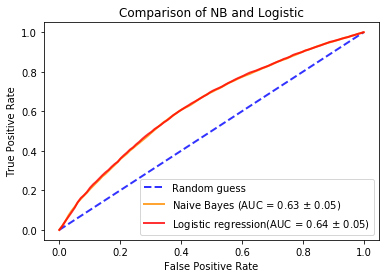

In [22]:
# Ajustar clasificador bayesiano
tprs_nb, aucs_nb, mean_fpr_nb = cv_roc_nb( df[["term","verification_status","annual_inc_log"]], df.loan_status, 5)
# Ajustar logística
tprs_lgs, aucs_lgs, mean_fpr_lgs = cv_roc(df_log2[["Intercept","term","verification_status","annual_inc"]], df.loan_status.cat.codes, 5)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
         label='Random guess', alpha=.8)

mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_nb[-1] = 1.0
mean_tpr_lgs = np.mean(tprs_lgs, axis=0)
mean_tpr_lgs[-1] = 1.0

mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
std_auc_nb = np.std(aucs_nb)
mean_auc_lgs = auc(mean_fpr_lgs, mean_tpr_lgs)
std_auc_lgs = np.std(aucs_lgs)

plt.plot(mean_fpr_nb, mean_tpr_nb, color='darkorange',
         label=r'Naive Bayes (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_nb, std_auc_nb),
         lw=2, alpha=.8)
plt.plot(mean_fpr_lgs, mean_tpr_lgs, color='red',
         label=r'Logistic regression(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_lgs, std_auc_lgs),
         lw=2, alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Comparison of NB and Logistic')
plt.show()

El clasificador bayesiano tiene un AUC ligeramente menor al del modelo logístico. Esto puede darse por las altas coreelaciones entre las covariables. Pero la diferencia no es mucha...

### ¿Cuál usar? (5 mts)

El estándar para decidir debería siempre incluir el desempeño de la predicción (AUC). A parte de esto, hay otros factores:

1. Propósito del análisis: si se requieren resultados rápidos, el bayesiano es indicado.
2. Número de observaciones: si se cuenta con un conjunto de datos gigante, el clasificador bayesiano es ideal puesto que solo calcula medias y varianzas. La logística al seguir un proceso de optimización, puede ser muy lento.
3. Número de covariables: con un alto número de variables, el bayesiano también es preferible.

En nuestro caso, ambos algoritmos funcionan bien.

## Árboles de decisión y bosques aleatorios (40 mts)

Los nodos del fondo del árbol son llamados hojas, mientras que todos los demás son internos o ramas. Cada uno contiene un número específico de muestras (`samples=`). La proporción de cumplidos y morosos se indican por `value=`. Los resultados se indican por `class=`.

Cuando se quiere predecir se empieza por el nodo más superior, este nodo indica la dirección para ir basado en el valor de `annual_inc`. Se recorre el árbol hasta llegar a una hoja. El resultado predecido de la hoja corresponde al de la muestra.

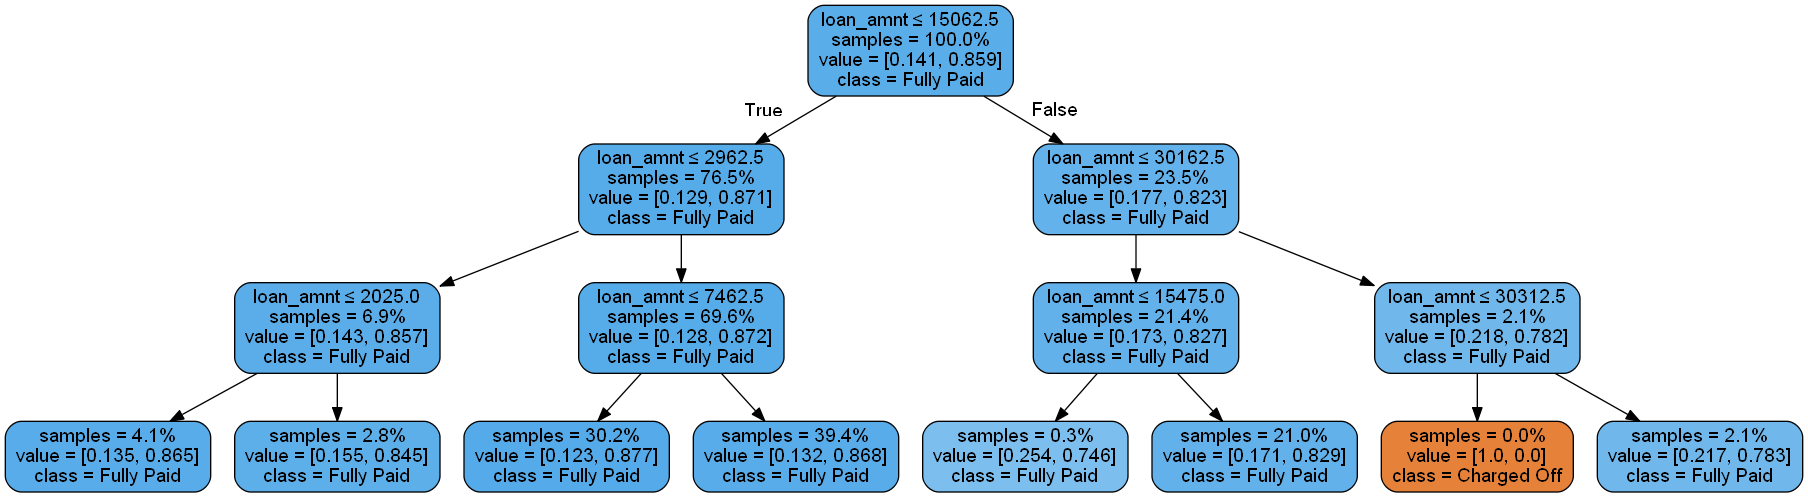

In [23]:
clf = DecisionTreeClassifier(max_depth = 3)

# Entrenar clasificador de árbol de decisión
clf = clf.fit(df[["loan_amnt"]], df.loan_status.cat.codes)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = ["loan_amnt"],
                class_names=['Charged Off', 'Fully Paid'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity = False, proportion = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Ejercicio 11: (10 mts)

Usa la función `train_test_split` del paquete `sklearn`, selecciona 75% de la muestra de forma aleatoria para entrenamiento y ajusta un árbol de decisión con la covariable `annual_inc`. Evalua la precisión del árbol.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df[["loan_amnt"]], \
                                                    df.loan_status.cat.codes, test_size = 0.25, \
                                                    random_state = 1)
clf_new = DecisionTreeClassifier()
clf_new = clf_new.fit(X_train, y_train)

y_pred_train = clf_new.predict(X_train)
y_pred_test = clf_new.predict(X_test)

print("Accuracy in training set:", accuracy_score(y_train, y_pred_train))
print("Accuracy in the other samples:", accuracy_score(y_test, y_pred_test))

Accuracy in training set: 0.8617886178861789
Accuracy in the other samples: 0.8524336054562365


**Respuesta.**
La precisión para el conjunto de prueba bajó 0.1, pero consideremos que hay mayor cantidad de morosos que de cumplidos.

### Umbral de decisión de un árbol de decisión (5 mts)

Puede ser no lineal, normalmente se ven como parches debido a que se está dicotomizando el conjunto de datos en múltiples niveles. Lo siguiente es un ejemplo para un árbol construido con `annual_inc` y `loan_amnt`:

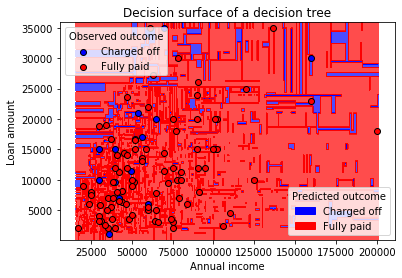

In [25]:
n_classes = 2
plot_colors = "br"

labels = ["Charged off", "Fully paid"]

clf = DecisionTreeClassifier().fit(df[["annual_inc","loan_amnt"]], df.loan_status.cat.codes)

# Graficar el umbral de decisión
plot_step = 100
viridis = cm.get_cmap('viridis', 2)
newcolors = viridis(np.linspace(0, 1, 2))
blue = np.array([0, 0, 1, 1])
red = np.array([1, 0, 0, 1])
newcolors[0, :] = blue
newcolors[1, :] = red
newcmp = ListedColormap(newcolors)

np.random.seed(0)
idx_plot = np.random.choice(df.shape[0], 100, replace = False )
df_plot = df.iloc[idx_plot]

x_min, x_max = df_plot.annual_inc.min() - 1000, df_plot.annual_inc.max() + 1000
y_min, y_max = df_plot.loan_amnt.min() - 1000, df_plot.loan_amnt.max() + 1000
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

fig, ax = plt.subplots()
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=newcmp, alpha = 0.7)

plt.xlabel("Annual income")
plt.ylabel("Loan amount")
plt.axis("tight");

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(df_plot.loan_status.cat.codes == i)
    plt.scatter(df_plot.iloc[idx].annual_inc, df_plot.iloc[idx].loan_amnt, c=color, 
                label=labels[i], edgecolors = "black")

legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='Charged off'),
                   Patch(facecolor='red', edgecolor='red',
                         label='Fully paid')]

plt.axis("tight")
plt.title("Decision surface of a decision tree")
leg1 = ax.legend(loc='upper left', title = "Observed outcome")
ax.legend(handles=legend_elements, loc = 'lower right', title = 'Predicted outcome');
ax.add_artist(leg1);

### Bosque aleatorio para mejorar el desempeño del árbol de decisión (15 mts)

Bien podría ser el algoritmo más popular para tareas de regresión y clasificación. La idea básica es contruir muchos árboles de decisión, luego utilizar un mecanismo de votación que produce la predicción final. Cuando se entrenan estos árboles individuales, se ejecuta un proceso de validación cruzada. Como resultado, el problema de sobreajuste se resuelve en gran parte.

Árbol de decisión con las covariables `term` y `annual_inc` y generemos la curva ROC sobre los datos de entrenamiento:

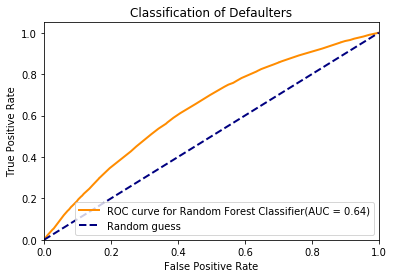

In [27]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf_rf.fit( df_log2[['annual_inc','term']], df.loan_status.cat.codes )
clf_rf_probas = clf_rf.predict_proba(df_log2[['annual_inc','term']])

roc_p = roc_curve(df.loan_status.cat.codes, clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
lw = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=lw, label='ROC curve for Random Forest Classifier(AUC = %0.2f)' % auc_p)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc="lower right")
plt.show()

### Ejercicio 12: (10 mts)

Usa `cv_roc` como plantilla para escribir una función `cv_roc_tree` que genere una VC de 5 pliegues para un árbol de decisión y un árbol de decisión con las covariables 
`term` and `annual_inc`. ¿Qué diferencia se ve?

In [28]:
def cv_roc_tree(X, y, n_split, algo = 'Tree'):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        if algo=="Tree":
            clf = DecisionTreeClassifier()
        else:
            clf = RandomForestClassifier(n_estimators=100, max_depth = 3, random_state=0)
                
        clf = clf.fit(X.iloc[train], y.iloc[train])
        probas_ = clf.predict_proba( X.iloc[test] )
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and w

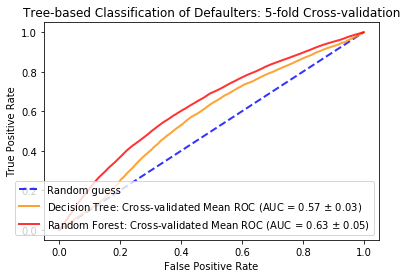

In [29]:
tprs_t, aucs_t, mean_fpr_t = cv_roc_tree( df_log2[["term","annual_inc"]], df.loan_status.cat.codes, 5)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree( df_log2[["term","annual_inc"]], df.loan_status.cat.codes, 5, algo = "forest")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
         label='Random guess', alpha=.8)

mean_tpr_t = np.mean(tprs_t, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_t[-1] = 1.0
mean_tpr_f[-1] = 1.0

mean_auc_t = auc(mean_fpr_t, mean_tpr_t)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
std_auc_t = np.std(aucs_t)
std_auc_f = np.std(aucs_f)

plt.plot(mean_fpr_t, mean_tpr_t, color='darkorange',
         label=r'Decision Tree: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_t, std_auc_t),
         lw=2, alpha=.8)
plt.plot(mean_fpr_f, mean_tpr_f, color='red',
         label=r'Random Forest: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_f, std_auc_f),
         lw=2, alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Tree-based Classification of Defaulters: 5-fold Cross-validation')
plt.show()

**Respuesta** Se observa un incremento en el AUC utilizando bosque aleatorio. Con solo 2 covariables. Esta diferencia es todavía más pronunciada utilizando más covariables.

## Seleccionando el mejor modelo (10 mts)

Hasta ahora hemos explorado 4 modelos de clasificación. También conocimos sobre la poderosa herramienta de comparación: validación cruzada. Ahora comparemos todos los modelos con las variables, exceptuando el árbol de decisión:

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.interp i

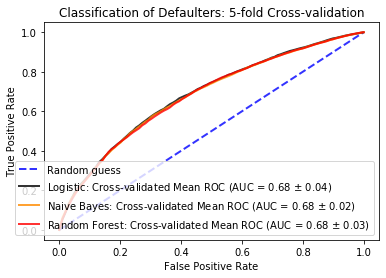

In [30]:
tprs_nb, aucs_nb, mean_fpr_nb = cv_roc_nb( df.drop(["loan_status","loan_amnt","annual_inc"], axis=1), df.loan_status, 5)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree( df_log2.drop("Intercept", axis=1), df.loan_status.cat.codes, 5, algo = "forest")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
         label='Random guess', alpha=.8)

mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_nb[-1] = 1.0
mean_tpr_f[-1] = 1.0

mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
std_auc_nb = np.std(aucs_nb)
std_auc_f = np.std(aucs_f)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='black',
         label=r'Logistic: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_vs, std_auc_vs),
         lw=2, alpha=.8)
plt.plot(mean_fpr_nb, mean_tpr_nb, color='darkorange',
         label=r'Naive Bayes: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_nb, std_auc_nb),
         lw=2, alpha=.8)
plt.plot(mean_fpr_f, mean_tpr_f, color='red',
         label=r'Random Forest: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_f, std_auc_f),
         lw=2, alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Classification of Defaulters: 5-fold Cross-validation')
plt.show()

Los 3 modelos arrojan resultados similares, pero si en un futuro la cantidad de observaciones o variables se incrementan demasiado, se debería priorizar el clasificador bayesiano.

## Conclusiones (5 mts)



En este caso, se exploramos nuevos modelos de clasificación y las ventajas y desventajas que poseen. Aunque se le llame ingenuo al clasificador bayesiano, este puede tener la ventaja en varias situaciones.

## Aprendizajes (5 mts)

Regresión logística, clasificador bayesiano, y los modelos basados en árboles son buenas alternativas para problemas de clasificación, y podemos compararlos a través de validación cruzada.